In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
import csv
import cv2

lines = []

with open("./data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

lines = lines[1:]
        
images = []
measurements = []

for line in lines:
    source_path = "./data/" + line[0]
    image = cv2.imread(source_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
X_data = np.array(images)
y_data = np.array(measurements)

np.save("./data/X_data.npy", X_data)
np.save("./data/y_data.npy", y_data)

In [27]:
X_data = np.load("./data/X_data.npy")
y_data = np.load("./data/y_data.npy")

In [5]:
y_data

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

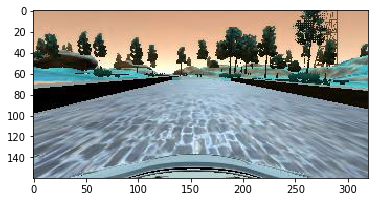

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_data[0])

In [8]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Lambda, Convolution2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(64, 3, 3, activation="elu"))
model.add(Convolution2D(64, 3, 3, activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_data, y_data, validation_split=0.2, shuffle=True, nb_epoch=7)

model.save('model.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/7
6428/6428 [==============================] - 203s - loss: 0.2268 - val_loss: 0.0138

* Image pre-processing:
  * RGB conversion after reading images, fixed that (!)
  * BGR2RGB conversion (since I'm importing images with cv2)
  * YUV color spaces instead of RGB
  * Try shadow and brightness augmentation
  * Cropping top 70, bottom 25 px using Cropping2D in keras (per video)

* Data augmenting/filtering
  * Exclude something like 70% of the images with abs(sterring_angles) <= 0.85.
  * Using left, right, and center images (with +/- 0.2 steering adjustment for left/right)
  * flipping all 3 of them and *-1.0 steering angle (total of 6 images per .xls line item)

* Model architecture
  * Use NVIDIA architecture
  * Changed the dropout layer location: 2 dropout layers after fully connected layers begin
  * change RELU to ELU. Changed initial weights (kernel_initializer) to he_normal from default

* Training
 * train model with large data first (6-7 epochs) and retrained with smaller datasets in problem areas with 1/10th learning rate.